In [102]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

In [103]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
# lat, lon = 38.904722, -77.016389 # Washington, DC
# lat, lon = 35.978611, -78.9 # Durham, NC
# lat, lon = 40.712778, -74.006111 # New York, NY
lat, lon = 41.711469, -71.191548 # Somerset, MA
delta = 0.1

bbox_of_interest = [lon - delta, lat - delta, lon + delta, lat + delta]

time_of_interest = "2024-05-01/2024-08-28" # Summer months
# time_of_interest = "2024-01-01/2024-03-28" # Winter months

In [ ]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {"lt": 10},
        "platform": {"in": ["landsat-8", "landsat-9"]},
    },
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 7 Items


In [106]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC09_L2SP_012031_20240625_02_T1 from 2024-06-25 with 3.27% cloud cover


In [107]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [108]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset> Size: 5MB
Dimensions:      (y: 755, x: 575)
Coordinates:
  * y            (y) float64 6kB 4.631e+06 4.631e+06 ... 4.609e+06 4.609e+06
  * x            (x) float64 5kB 3.091e+05 3.091e+05 ... 3.262e+05 3.263e+05
    spatial_ref  int32 4B 32619
    time         datetime64[ns] 8B 2024-06-25T15:26:09.688745
Data variables:
    nir08        (y, x) uint16 868kB 21602 20987 20394 ... 22823 22245 21003
    red          (y, x) uint16 868kB 9088 9059 9335 8559 ... 8085 7987 8089 8177
    green        (y, x) uint16 868kB 9744 9682 9642 9201 ... 8787 8672 8819 8890
    blue         (y, x) uint16 868kB 8646 8637 8617 8290 ... 8033 7977 8067 8109
    qa_pixel     (y, x) uint16 868kB 21824 21824 21824 ... 21824 21824 21824
    lwir11       (y, x) uint16 868kB 46162 46081 46084 ... 45237 45082 44962

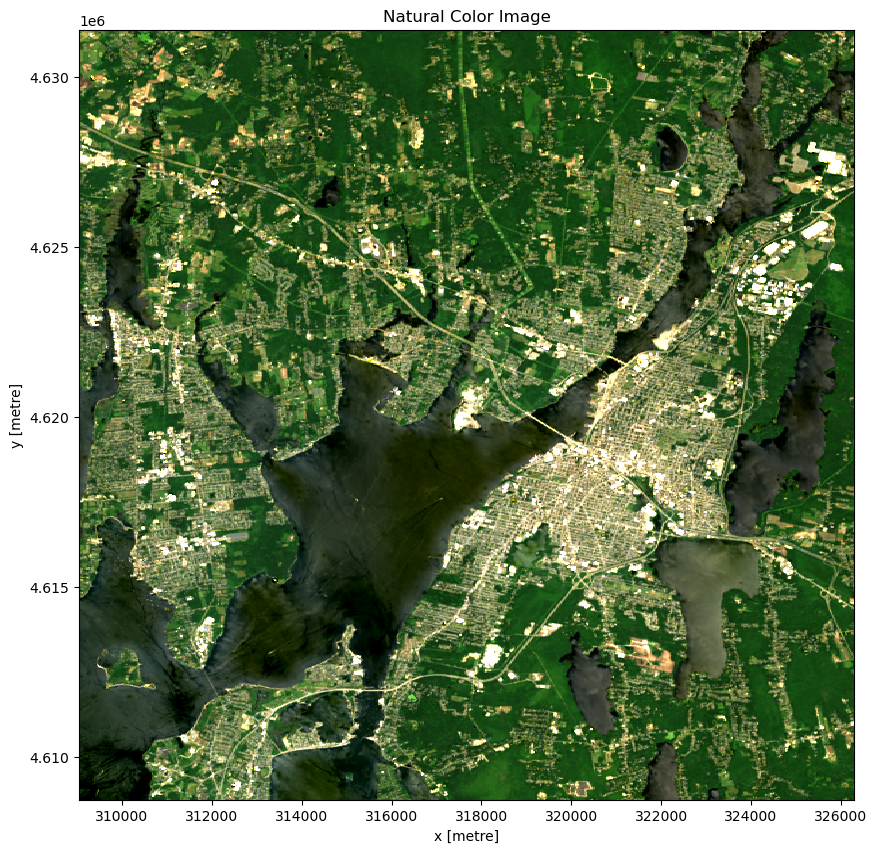

In [109]:
fig, ax = plt.subplots(figsize=(10, 10))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color Image");

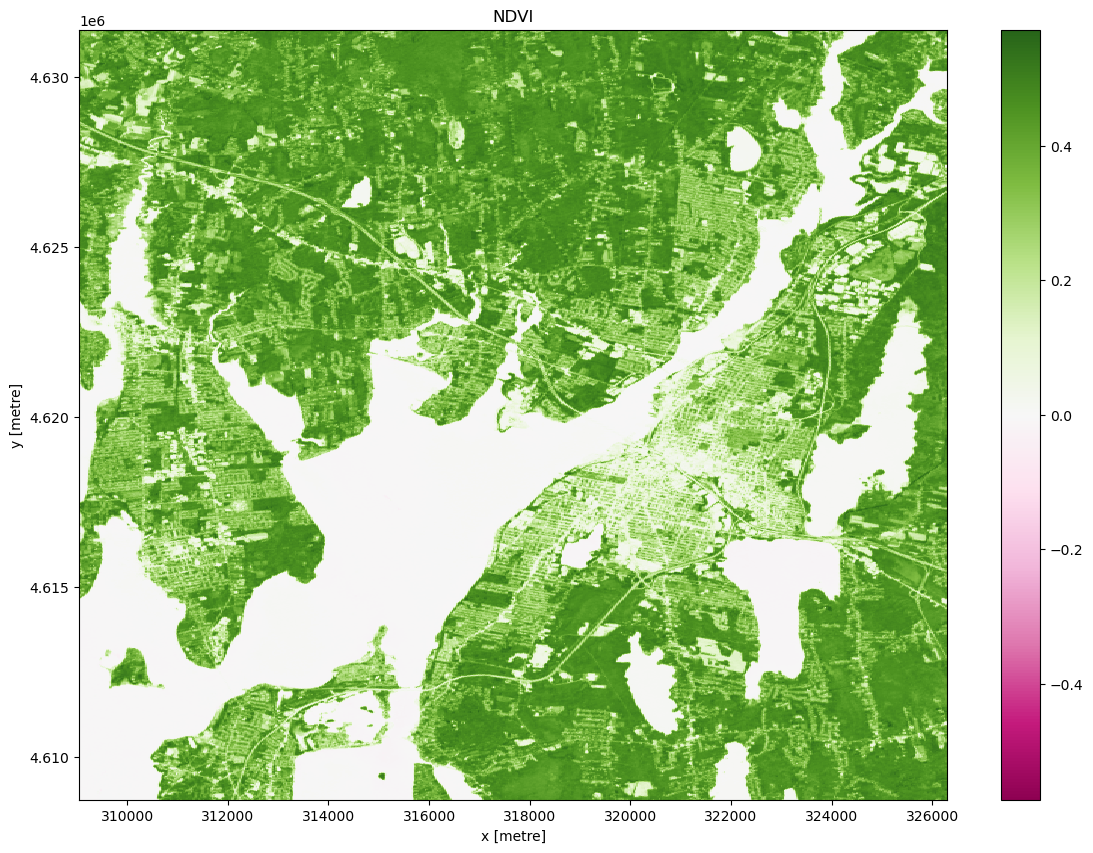

In [122]:
red = data["red"].astype("float")
nir = data["nir08"].astype("float")
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(14, 10))
ndvi.plot.imshow(ax=ax, cmap="PiYG")
ax.set_title("NDVI");


In [111]:
band_info = selected_item.assets["lwir11"].extra_fields["raster:bands"][0]
band_info

{'unit': 'kelvin',
 'scale': 0.00341802,
 'nodata': 0,
 'offset': 149.0,
 'data_type': 'uint16',
 'spatial_resolution': 30}

In [ ]:
temperature = data["lwir11"].astype(float)

# Replace missing values with median
temperature.data[temperature.data == band_info["nodata"]] = data["lwir11"].median().values

# Convert to Kelvin
temperature *= band_info["scale"]
temperature += band_info["offset"]
temperature[:5, :5]

<xarray.DataArray 'lwir11' (y: 5, x: 5)> Size: 200B
array([[306.78263924, 306.50577962, 306.51603368, 306.59123012,
        307.05608084],
       [307.02190064, 306.93986816, 307.06291688, 307.14836738,
        307.40130086],
       [306.56388596, 306.73820498, 307.07658896, 307.34661254,
        307.52434958],
       [305.83242968, 306.3485507 , 306.73478696, 307.12102322,
        307.4081369 ],
       [305.26845638, 305.79141344, 306.2801903 , 306.741623  ,
        307.1005151 ]])
Coordinates:
  * y            (y) float64 40B 4.631e+06 4.631e+06 ... 4.631e+06 4.631e+06
  * x            (x) float64 40B 3.091e+05 3.091e+05 ... 3.092e+05 3.092e+05
    spatial_ref  int32 4B 32619
    time         datetime64[ns] 8B 2024-06-25T15:26:09.688745
Attributes:
    nodata:   0

/var/folders/m6/8k94r84d6qq_67mq2lnhvrzh0000gn/T/ipykernel_33015/2765371238.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("coolwarm", 15)


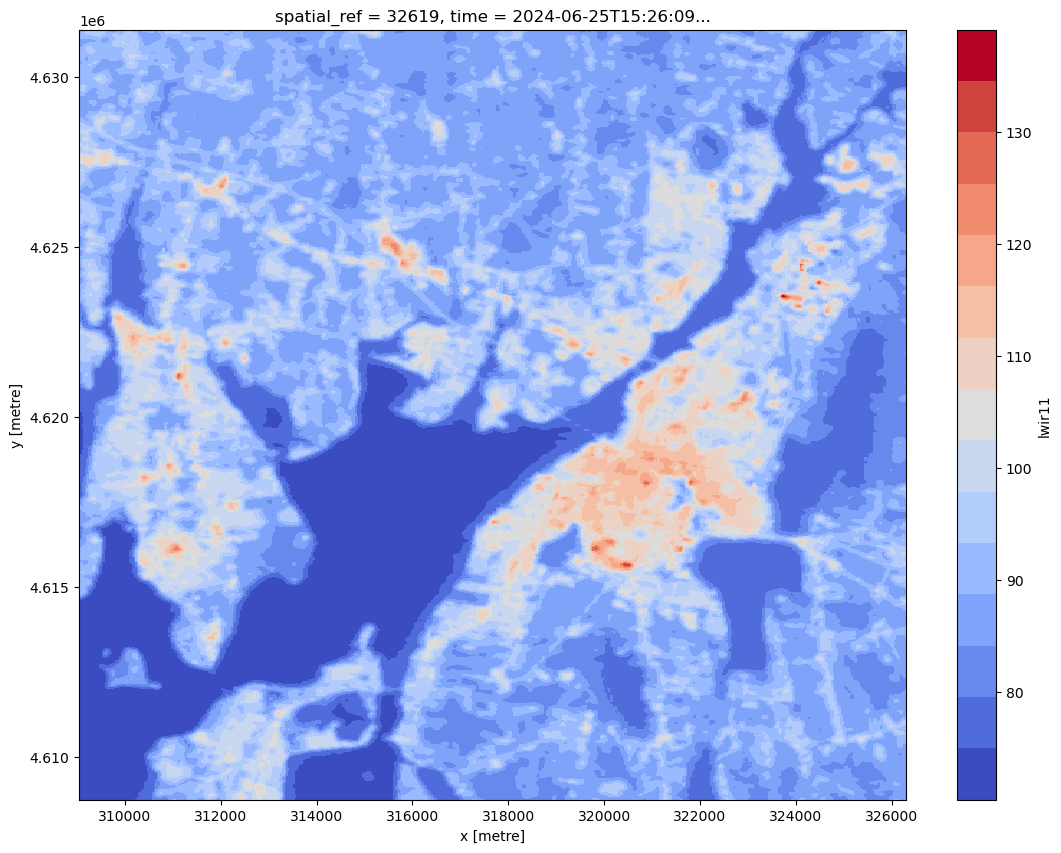

In [ ]:
celsius = temperature - 273.15
fahrenheit = celsius * 9/5 + 32

discretize = True
if discretize:
    cmap = plt.cm.get_cmap("coolwarm", 15)
    fahrenheit.plot.imshow(cmap=cmap, size=10)
else:
    fahrenheit.plot.imshow(cmap = 'coolwarm', size=10)

In [128]:
fahrenheit.data

array([[92.53875063, 92.04040332, 92.05886062, ..., 86.66317425,
        87.09384477, 87.62295427],
       [92.96942115, 92.82176269, 93.04325038, ..., 86.73700348,
        87.35839952, 88.03516748],
       [92.14499473, 92.45876896, 93.06786013, ..., 86.76161323,
        87.48760068, 88.33048441],
       ...,
       [70.7099077 , 70.76527963, 70.75297476, ..., 85.149675  ,
        84.6205655 , 84.42368755],
       [70.67914552, 70.70375527, 70.6914504 , ..., 85.6972418 ,
        85.06354089, 84.63902281],
       [70.65453578, 70.64838334, 70.64838334, ..., 86.84774733,
        85.89411975, 85.15582743]])